# Double Pendulum

In [1]:
import ipywidgets as widgets
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
import time


from matplotlib import rc 
import matplotlib.animation as animation
from collections import deque
from IPython.display import HTML

In [2]:
from functions import MS_functions_MHE, generate_meas, cnlls_solver, MHE


from animate_double import get_cart_x, get_cart_y, get_ball1_x, get_ball1_y, get_ball2_x, get_ball2_y, animate_double_pendulum

In [3]:
file = open("../plots/DoublePendulum_graphic.png", "rb")
image = file.read()
widgets.Image(
    value=image,
    format='png',
    width=200,
    height=600,
)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\xaa\x00\x00\x01l\x08\x06\x00\x00\x00\x04\xdc\x9b…

## Implementing the model dynamics

In [4]:
# fixing parameters
g = 9.81
l1 = 0.323
l2 = 0.480
a1 = 0.2145
a2 = 0.223
m1 = 0.853
m2 = 0.510
J1 = 0.0126
J2 = 0.0185
#d1 = #0.005
#d2 = #0.005

In [5]:
# defining the rhs of the ODE system

# state variables
x1 = MX.sym('x1') #y
x2 = MX.sym('x2') #ydot
x3 = MX.sym('x3') #phi1
x4 = MX.sym('x4') #phi1dot
x5 = MX.sym('x5') #phi2
x6 = MX.sym('x6') #phi2dot
x = vertcat(x1,x2,x3,x4,x5,x6)

u = 0

#parameters
d1 = MX.sym('d1')
d2 = MX.sym('d2')
p = vertcat(d1,d2)

dM = (J1 + a1*a1*m1 + l1*l1*m2) * (J2 + a2*a2*m2) - a2*l1*m2*cos(x3-x5)*a2*l1*m2*cos(x3-x5)

f1 = (a1*m1 + l1*m2)*g*sin(x3) -a2*l1*m2*sin(x3-x5)*x6*x6 -d1*x4 - d2*(x4-x6) + (a1*m1+l1*m2)*cos(x3)*u

f2 = a2*g*m2*sin(x5) +a2*l1*m2*sin(x3-x5)*x4*x4 +d2*(x4-x6) +a2*m2*cos(x5)*u

# rhs
rhs_exp = vertcat(x2,
                  u,
                  x4,
                  1/dM *((J2+a2*a2*m2)*f1 -a2*l1*m2*cos(x3-x5)*f2),
                  x6,
                  1/dM *(-a2*l1*m2*cos(x3-x5)*f1+(J1+a1*a1*m1+l1*l1*m2)*f2))

rhs = Function('rhs',[x,p],[rhs_exp])

## Choose starting value, for which the measurements are obtained  

In [6]:
N = 10 #100 # number of integration steps
T = 0.5 #1 #10.0
L = 10 # -> insgesamt 5 sekunden

p_true = [0.05,0.1]

eps = 0.1
s0 = [0, 0, eps, 0, -0.5, 0]
x0 = s0 ## initial conditions from paper
Res1 = s0

dae = {'x': x, 'p': p, 'ode': rhs_exp}
opts = {'tf': T/N}
F = integrator('F', 'cvodes', dae, opts)

for i in range(L*N):
    Fi = F(x0=s0, p=p_true)
    Xk_end = Fi['xf']
    # for k in range(1,M+1):
    Res1 = vertcat(Res1,Xk_end[:,-1])
    s0 = Xk_end[:,-1]
print(Res1.shape)

(606, 1)


## Another simulation
for comparing the effect of the parameters onto the states

In [7]:
N = 10 #100 # number of integration steps
T = 0.5 #1 #10.0
L = 10 # -> insgesamt 5 sekunden

p_true_comp = [0.01,0.1]

eps = 0.1
s0 = [0, 0, eps, 0, -0.5, 0]
x0 = s0 ## initial conditions from paper
Res2 = s0

dae = {'x': x, 'p': p, 'ode': rhs_exp}
opts = {'tf': T/N}
F = integrator('F', 'cvodes', dae, opts)

for i in range(L*N):
    Fi = F(x0=s0, p=p_true_comp)
    Xk_end = Fi['xf']
    # for k in range(1,M+1):
    Res2 = vertcat(Res2,Xk_end[:,-1])
    s0 = Xk_end[:,-1]
print(Res2.shape)

(606, 1)


MovieWriter Pillow unavailable; using Pillow instead.


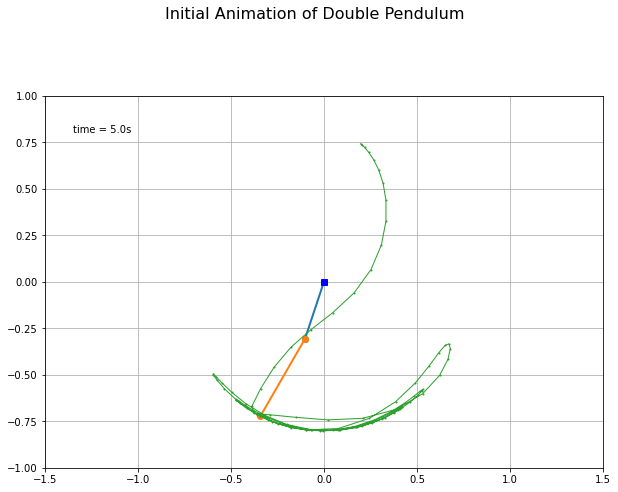

In [8]:
animate_double_pendulum("../plots/doubleinitialAnimation.gif", Res1,'Initial Animation of Double Pendulum', T=T, N=N)

## Generate synthetic measurements

In [9]:
# generate synthetic measurements of the states
sigma = 0.05
#p_true = [0.1,0.05] defined above
M = L*N
meas = generate_meas(x, p, rhs_exp, L*T, sigma, p_true, M, x0)

In [10]:
# we need to reshape for visualization
meas1 = []
for i in range(M+1):
    meas1 = vertcat(meas1,meas[:,i])
print(meas1.shape)

(606, 1)


MovieWriter Pillow unavailable; using Pillow instead.


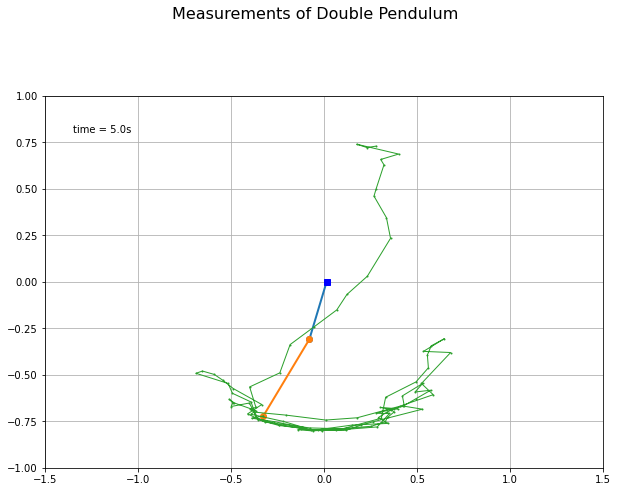

In [11]:
animate_double_pendulum("../plots/measurements.gif", meas1,'Measurements of Double Pendulum', T=T, N=N)

## Open loop PE for the first MHE time horizon only 
here the first N=10 shooting intervals (->11 measurements)

In [12]:
x_opt = 0
p_opt = 0
last_P = 0
last_W = 0

#print(meas[:,M])
FF1, FF2 = MS_functions_MHE(T, N, x, p, rhs_exp, meas[:,0:11], sigma, x_opt, p_opt, last_P, last_W)

In [13]:
p0= [0,0]
w0 = vertcat(meas1[:x.shape[0]*11],p0)
w = MX.sym('w',w0.shape[0])
#k=0
y = meas[:,10]
#print(y.shape)
F1 = Function('F1',[w],[FF1(w,y)])
F2 = Function('F2',[w],[FF2(w,y)])

In [14]:
w_opt = cnlls_solver(F1, F2, w0, itmax=1, tol=1e-7, ggn = True, show_iteration = False)

In [15]:
pp_opt = w_opt[(N+1)*x.shape[0]:]
ss_opt = w_opt[0:(N+1)*x.shape[0]]
print(pp_opt)
print(ss_opt.shape)

[0.06994839 0.09189487]
(66,)


MovieWriter Pillow unavailable; using Pillow instead.


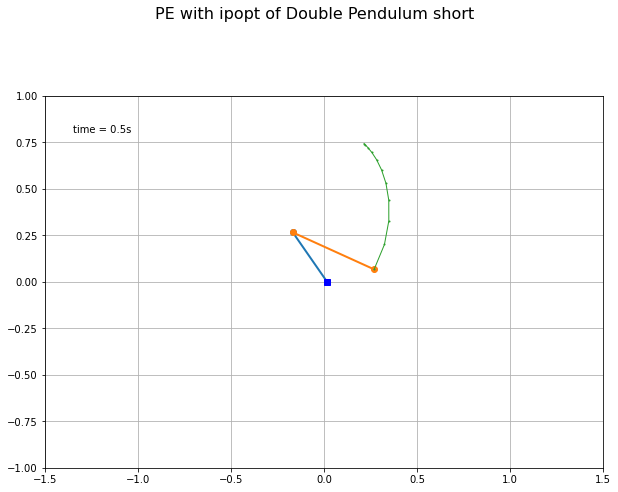

In [16]:
animate_double_pendulum("../plots/ipopt_short.gif", ss_opt,'PE with ipopt of Double Pendulum short', T=T, N=N)

## Open loop PE for all measurements

In [17]:
#p0 = [0,0]
x_opt = 0
p_opt = 0
last_P = 0
last_W = 0

#print(meas[:,M])
FF1, FF2 = MS_functions_MHE(L*T, L*N, x, p, rhs_exp, meas, sigma, x_opt, p_opt, last_P, last_W)

In [18]:
p0= [0,0]
w0 = vertcat(meas1,p0)
ww = MX.sym('ww',w0.shape[0])
#k=0
y = meas[:,M]
#print(y.shape)
F1 = Function('F1',[ww],[FF1(ww,y)])
F2 = Function('F2',[ww],[FF2(ww,y)])
#print(F1)
#print(F2)

In [19]:
w_opt = cnlls_solver(F1, F2, w0, itmax=1 , tol=1e-7, ggn = True, show_iteration = False)

In [20]:
#print(w_opt)
#cut = int(L*N)
p_opt = w_opt[(L*N+1)*x.shape[0]:]
s_opt = w_opt[0:(L*N+1)*x.shape[0]]

In [21]:
print(p_opt)
print(s_opt.shape)

[0.04249059 0.08934333]
(606,)


MovieWriter Pillow unavailable; using Pillow instead.


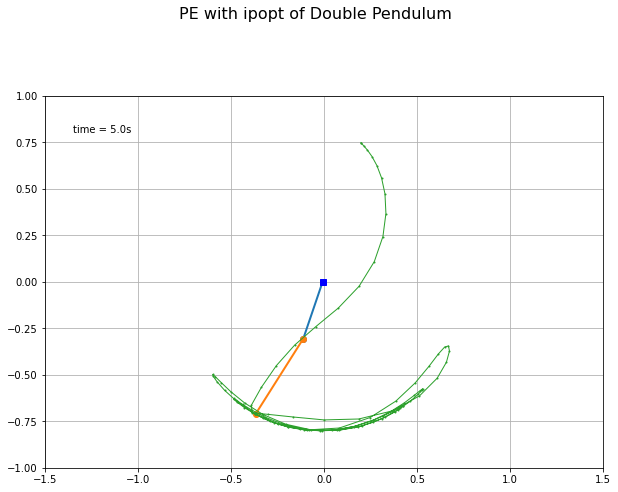

In [22]:
animate_double_pendulum("../plots/ipopt.gif", s_opt,'PE with ipopt of Double Pendulum', T=T, N=N)

# MHE

In [23]:
#x_opt = 0
#p_opt = 0
last_P = 0
last_W = 0


x0bar = 0
p0bar = 0
P = 0
p0 = [0.,0.]
r0 = vertcat(meas1[:(N+1)*x.shape[0]],p0)
#print(r0.shape)
T = 0.5
N = 10
length_simulation = 30
#sigma = 0.01 (defined above)
W = 0

In [24]:
xx, pp = MHE(x0bar, p0bar, P, r0, T, N, length_simulation, x, p, rhs_exp, meas, sigma, W, ggn = True)

starting (time horizon) loop no.  1
starting (time horizon) loop no.  2
starting (time horizon) loop no.  3
starting (time horizon) loop no.  4
starting (time horizon) loop no.  5
starting (time horizon) loop no.  6
starting (time horizon) loop no.  7
starting (time horizon) loop no.  8
starting (time horizon) loop no.  9
starting (time horizon) loop no.  10
starting (time horizon) loop no.  11
starting (time horizon) loop no.  12
starting (time horizon) loop no.  13
starting (time horizon) loop no.  14
starting (time horizon) loop no.  15
starting (time horizon) loop no.  16
starting (time horizon) loop no.  17
starting (time horizon) loop no.  18
starting (time horizon) loop no.  19
starting (time horizon) loop no.  20
starting (time horizon) loop no.  21
starting (time horizon) loop no.  22
starting (time horizon) loop no.  23
starting (time horizon) loop no.  24
starting (time horizon) loop no.  25
starting (time horizon) loop no.  26
starting (time horizon) loop no.  27
starting (

MovieWriter Pillow unavailable; using Pillow instead.


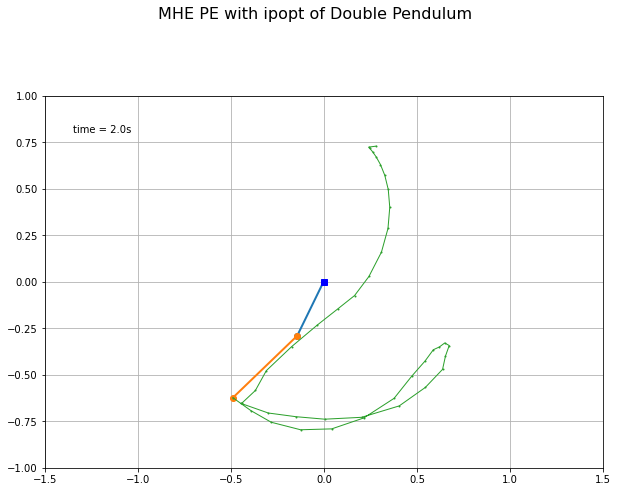

In [25]:
animate_double_pendulum("../plots/mhe.gif", xx,'MHE PE with ipopt of Double Pendulum', T=T, N=N)

C:\Users\49163\AppData\Local\Temp/ipykernel_8444/1441293854.py:49: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../plots/Comparison_trajectories.png',bbox='tight')


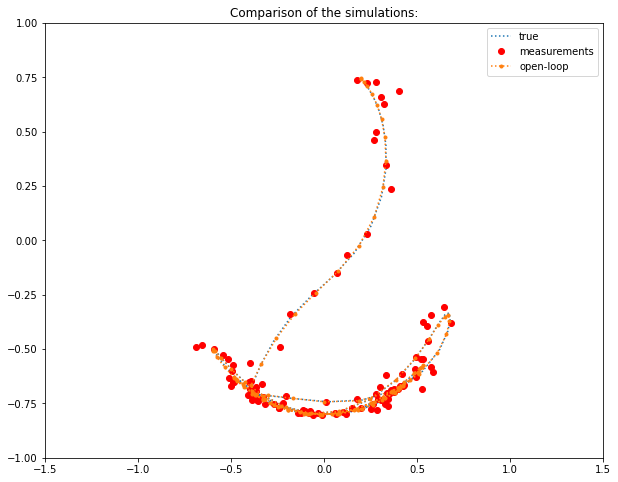

In [27]:
plt.figure(figsize=(10,8))
plt.title("Comparison of the simulations:")
plt.xlim(-1.5,1.5)
plt.ylim(-1.,1.)

ss = Res1 # true
s = np.array(ss).flatten()
ll = int(s.shape[0]/6)
x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
plt.plot(x3,y3,linestyle = 'dotted', label = "true")   

ss = Res2 # true comp
s = np.array(ss).flatten()
ll = int(s.shape[0]/6)
x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
#plt.plot(x3,y3,linestyle = 'dotted', label = "true comp")   

ss = meas1 # meas
s = np.array(ss).flatten()
ll = int(s.shape[0]/6)
x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
plt.plot(x3,y3, 'ro',label = "measurements")#, linestyle = 'dotted') 

ss = s_opt # open-loop
s = np.array(ss).flatten()
ll = int(s.shape[0]/6)
x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
plt.plot(x3,y3,marker = 'o', label = "open-loop", linestyle = 'dotted', ms = 3) 

ss = ss_opt # open-loop short
s = np.array(ss).flatten()
ll = int(s.shape[0]/6)
x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
#plt.plot(x3,y3,marker = 'o', label = "open-loop short", linestyle = 'dotted', ms = 3) 

ss = xx # mhe
s = np.array(ss).flatten()
ll = int(s.shape[0]/6)
x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
#plt.plot(x3,y3,marker = 'o', label = "mhe", linestyle = 'dotted', ms = 3)   
plt.legend()

plt.savefig('../plots/Comparison_trajectories.png',bbox='tight')

In [ ]:
def plot_widget(simulations): #, n):
    plt.figure(figsize=(10,8))
    plt.title("Comparison of the simulations:")
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.,1.)
    
    
    if 'true' in simulations:
        ss = Res1 # true
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/6)
        x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3,linestyle = 'dotted', label = "true")   

        
    if 'measured' in simulations:
        ss = meas1 # meas
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/6)
        x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3, 'ro',label = "measurements", ms = 5)#, linestyle = 'dotted') 
        
    if 'open-loop' in simulations:
        ss = s_opt # open-loop
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/6)
        x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3,marker = 'o', label = "open-loop", linestyle = 'dotted', ms = 3) 
        
    if 'open-loop short' in simulations:
        ss = ss_opt # open-loop short
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/6)
        x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3,marker = 'o', label = "open-loop short", linestyle = 'dotted', ms = 3) 
        
    if 'mhe' in simulations:
        ss = xx # mhe
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/6)
        x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3,marker = 'o', label = "mhe", linestyle = 'dotted', ms = 3)  
        
    plt.legend()
    plt.show()

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#from animate_double import plot_widget


interactive(plot_widget, simulations = widgets.SelectMultiple(
    options=['true', 'measured', 'open-loop', 'open-loop short','mhe'],
    rows = 5,
    description='Simulations:',
    disabled=False
))

In [ ]:
print(pp[pp.shape[0]-2:])
print(pp)
#print(xx.shape)

C:\Users\49163\AppData\Local\Temp/ipykernel_8444/1975286682.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../plots/Comparison_d1.png',bbox='tight')


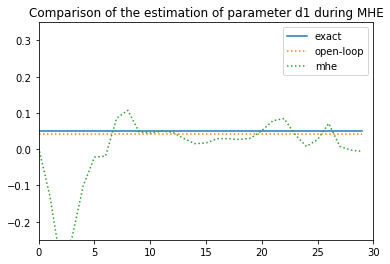

In [28]:
p_plot1 = pp[::2]
#print(p_opt[0])
p_ref1 = p_true[0]*np.ones(p_plot1.size()[0])
p_open_loop1 = p_opt[0]*np.ones(p_plot1.size()[0])

x_ax = range(p_plot1.size()[0]) 
plt.plot(x_ax,p_ref1, label = 'exact')
plt.plot(x_ax, p_open_loop1, label = 'open-loop', linestyle='dotted')
plt.plot(x_ax, p_plot1, label = 'mhe', linestyle='dotted')
plt.title('Comparison of the estimation of parameter d1 during MHE')
plt.xlim(0,p_plot1.size()[0])
plt.ylim(p_true[0]-0.3,p_true[0]+0.3) #plt.ylim(-0.4,0.1)
plt.legend()
plt.savefig('../plots/Comparison_d1.png',bbox='tight')

C:\Users\49163\AppData\Local\Temp/ipykernel_8444/321642935.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../plots/Comparison_d2.png',bbox='tight')


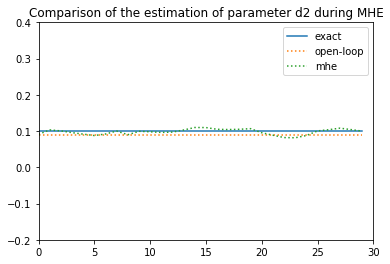

In [29]:
p_plot2 = pp[1::2]
#print(p_plot)
p_ref2 = p_true[1]*np.ones(p_plot2.size()[0])
p_open_loop2 = p_opt[1]*np.ones(p_plot2.size()[0])

x_ax = range(p_plot2.size()[0]) 
plt.plot(x_ax,p_ref2, label = 'exact')
plt.plot(x_ax, p_open_loop2, label = 'open-loop', linestyle='dotted')
plt.plot(x_ax, p_plot2, label = 'mhe', linestyle= 'dotted')
plt.title('Comparison of the estimation of parameter d2 during MHE')
plt.xlim(0,p_plot2.size()[0])
plt.ylim(p_true[1]-0.3,p_true[1]+0.3)#plt.ylim(-0.2,0.3) ## Attention works only for this special choice of parameter!
plt.legend()
plt.savefig('../plots/Comparison_d2.png',bbox='tight')

C:\Users\49163\AppData\Local\Temp/ipykernel_8444/1743197752.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../plots/Comparison_rel_error.png',bbox='tight')


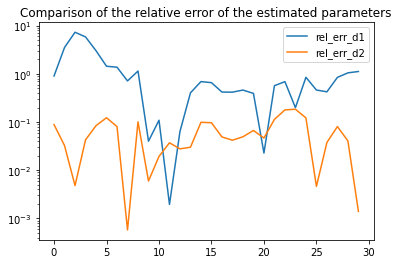

In [30]:
## relative error
## for d1:
rel_err1 = np.zeros(p_plot1.size()[0])
for i in x_ax:
    rel_err1[i]=np.abs(p_plot1[i]-p_ref1[i])/p_ref1[i]
    #rel_err1.append(np.abs(p_plot1[i]-p_ref[i])/p_ref[i])
#print(rel_err1)

## for d1:
rel_err2 = np.zeros(p_plot2.size()[0])
for i in x_ax:
    rel_err2[i]=np.abs(p_plot2[i]-p_ref2[i])/p_ref2[i]
    #rel_err1.append(np.abs(p_plot1[i]-p_ref[i])/p_ref[i])
#print(rel_err2)

plt.plot(x_ax, rel_err1, label='rel_err_d1')
plt.plot(x_ax, rel_err2, label = 'rel_err_d2')
plt.yscale('log')
plt.title('Comparison of the relative error of the estimated parameters')
plt.legend()
plt.savefig('../plots/Comparison_rel_error.png',bbox='tight')